In [6]:
from scipy.stats import pearsonr as R
from scipy.stats import spearmanr as rho
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
exp_data = pd.read_csv("exp_data.txt",sep='\t')

Tm_correlation_dict = {'methods':[],'rho':[],'rho_p':[],'r':[],'r_p':[]}
U_correlation_dict = {'methods':[],'rho':[],'rho_p':[],'r':[],'r_p':[]}

def plot(key, c):
    _rho = "{:.4f}".format(rho(score, exp_data[key][exp_data['U/mg'] > c])[0])
    _rho_p = "{:.5f}".format(rho(score, exp_data[key][exp_data['U/mg'] > c])[1])
    _R = "{:.4f}".format(R(score, exp_data[key][exp_data['U/mg'] > c])[0])
    _R_p = "{:.5f}".format(R(score, exp_data[key][exp_data['U/mg'] > c])[1])
    label = f"rho: {_rho}\nR: {_R}"
    ax = sns.regplot(x=score, y=exp_data[key][exp_data['U/mg'] > c],label=label)
    ax.legend()
    plt.show()
    _rho, _rho_p = rho(score, exp_data[key][exp_data['U/mg'] > c])
    _R, _R_p = R(score, exp_data[key][exp_data['U/mg'] > c])
    return _rho, _rho_p, _R, _R_p

In [2]:
import torch
import seaborn as sns

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')


# model = TransformerWrapper(
#     num_tokens = 25,
#     max_seq_len = 512,
#     attn_layers = Encoder(
#         dim = 512,
#         depth = 3,
#         heads = 8
#     )
# )
# model.load_state_dict(torch.load(f'./cu_bert.pth'))
# model.to(device)
# model.eval()

model = torch.load('./models/pretrained-model_19.pt').to(device)
model.eval()

def read_vocab(vocab_file):
    vocab_dict = {}
    with open(vocab_file, 'r') as vocab_file:
        for i, line in enumerate(vocab_file):
            vocab = line.replace("\n", "")
            vocab_dict[vocab] = i
    return vocab_dict

vocab = read_vocab('vocab.txt')

def tokenizer(seq):
    x = torch.zeros(len(seq)+2)
    x[0] = 2
    for i, aa in enumerate(seq):
        w = vocab.get(aa)
        if w:
            x[i+1] = w
        else:
            x[i+1] = 1
    x[-1] = 3
    return x.long()

def check_heatmap():
    raw_sequence = "SNPYQRGPNPTRSALTTDGPFSVATYSVSRLSVSGFGGGVIYYPTGTTLTFGGIAMSPGYTADASSLAWLGRRLASHGFVVIVINTNSRLDFPDSRASQLSAALNYLRTSSPSAVRARLDANRLAVAGHSMGGGATLRISEQIPTLKAGVPLTPWHTDKTFNTPVPQLIVGAEADTVAPVSQHAIPFYQNLPSTTPKVYVELDNATHFAPNSPNAAISVYTISWMKLWVDNDTRYRQFLCNVNDPALSDFRSNNRHCQ"

    inp = tokenizer(raw_sequence).view(1, -1)
    map = []
    for i, w in enumerate(raw_sequence):
        wild = vocab[w]
        # print(wild)
        inp[0][i] = 4
        with torch.no_grad():
            y = model(inp.to(device))
            # torch.argmax(y[0].cpu(), dim=1)[i]
            # print(y[0].cpu()[i].numpy(),y[0].cpu()[i].numpy()[wild] )
            map.append(list(y[0].cpu()[i].numpy() - y[0].cpu()[i].numpy()[wild])[5:])

    # sns.heatmap(map)
    return map

map = check_heatmap()

# ave = []

# for i in range(20):
#     model = torch.load(f'pretrained-model_{i}.pt').to(device)
#     map = check_heatmap()
#     ave.append(np.mean(map))

# sns.lineplot(x=[i+1 for i in range(len(ave))], y=ave)

In [7]:
raw_sequence = "SNPYQRGPNPTRSALTTDGPFSVATYSVSRLSVSGFGGGVIYYPTGTTLTFGGIAMSPGYTADASSLAWLGRRLASHGFVVIVINTNSRLDFPDSRASQLSAALNYLRTSSPSAVRARLDANRLAVAGHSMGGGATLRISEQIPTLKAGVPLTPWHTDKTFNTPVPQLIVGAEADTVAPVSQHAIPFYQNLPSTTPKVYVELDNATHFAPNSPNAAISVYTISWMKLWVDNDTRYRQFLCNVNDPALSDFRSNNRHCQ"
scores = []
mutations = []
for i, (p, w) in enumerate(zip(map, raw_sequence)):
    for aa, score in zip(list(vocab.keys())[5:], p):
        mutations.append(w+str(i+36)+aa)
        scores.append(score)
preds = dict(zip(mutations,scores))
preds['S57P']
def get_score(x):
    return preds[x.replace(" ","")]
score = exp_data['mutation'][exp_data['Tm'] > 0].apply(get_score)
# plot('Tm',0)
exp_data['score'] = score
group = np.array([exp_data['U/mg'] > 20.5],dtype=int)
exp_data['group'] = group.reshape(-1, 1)

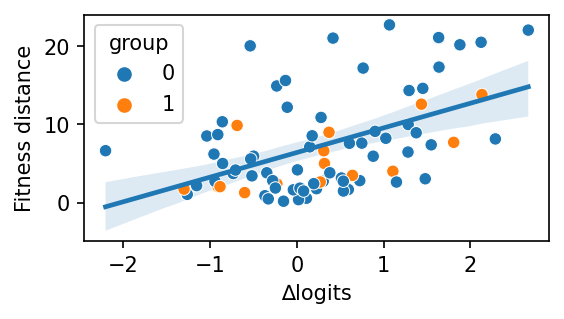

In [8]:
import matplotlib.pyplot as plt
fig = plt.subplots(figsize=(4,2),dpi=150)

ax = sns.regplot(x = exp_data['score'], 
                    y = ((exp_data['U/mg']-20.5)**2 + (exp_data['Tm']-85)**2)**0.5, 
                    scatter = False
                    # hue=exp_data['group']
                    )

ax = sns.scatterplot(x = exp_data['score'], 
                    y = ((exp_data['U/mg']-20.5)**2 + (exp_data['Tm']-85)**2)**0.5, 
                    hue=exp_data['group']
                    )

ax.set_xlabel("∆logits")
ax.set_ylabel("Fitness distance")
plt.show()